# АНАЛИТИКА В АВИАКОМПАНИИ (МИНИ-ПРОЕКТ)

Заказчиком поставлена задача изучить базу данных внутренних пассажирских авиаперевозок и понять предпочтения пользователей, покупающих билеты на те или иные направления. Какие направления самые популярные? в какие города прибывает больше всего рейсов? какие модели самолетов в-основном используются для внутренних пассажирских авиаперевозок?

В нашем распоряжении имеется информация о количестве совершенных рейсов в месяц в разрезе моделей самолетов (период - сентябрь 2018) и о среднем количестве рейсов в день, прибывающих в тот или иной российский город (период выборки - август 2018).

## Ознакомление с данными и предобработка

Импортируем необходимые библиотеки и взглянем на данные

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import plotly.express as px
from scipy.stats import norm
import warnings

In [2]:
warnings.filterwarnings("ignore") 

model = pd.read_csv('https://code.s3.yandex.net/datasets/query_1.csv')
city = pd.read_csv('https://code.s3.yandex.net/datasets/query_3.csv')

model
model.info()

model  flights_amount
0      Airbus A319-100             607
1      Airbus A321-200             960
2       Boeing 737-300             630
3       Boeing 767-300             600
4       Boeing 777-300             300
5   Bombardier CRJ-200            4446
6   Cessna 208 Caravan            4557
7  Sukhoi SuperJet-100            4185

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   model           8 non-null      object
 1   flights_amount  8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


Таблица **model** состоит из 8 строк и 2 столбцов. Первый столбец - названия моделей самолетов (тип данных строковый), второй - количество рейсов, которые осуществили самолеты данной модели в сентябре 2018 года (тип данных - целочисленный). Тип данных нас устраивает, пропусков, дубликатов и видимых аномалий нет.

Посмотрим на второй датасет

In [3]:
city
city.info()

city  average_flights
0            Абакан         3.870968
1           Анадырь         1.000000
2             Анапа         2.161290
3       Архангельск         5.354839
4         Астрахань         2.451613
..              ...              ...
96             Чита         1.580645
97           Элиста         4.870968
98   Южно-Сахалинск         4.290323
99           Якутск         2.741935
100       Ярославль         1.322581

[101 rows x 2 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             101 non-null    object 
 1   average_flights  101 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [4]:
city.describe()
city.duplicated().mean()

average_flights
count       101.000000
mean          5.494189
std          13.119790
min           1.000000
25%           2.000000
50%           3.000000
75%           5.870968
max         129.774194

0.0

Таблица **city** содержит столбец с названиями российских городов (101 строка, тип данных - object) и столбец со средним значением количества рейсов в день для данного города (период выборки - август 2018 года). Тип данных столбца `average_flights` - число с плавающей точкой. 

Минимальное значение столбца `average_flights` - 1 перелет, максимальное 129, среднее 5. На первый взгляд отклонения в данных отсутствуют, пропущенных значений и полных дубликатов также нет.

Для удобства работы округлим среднее количество перелетов в день до целых значений.

In [5]:
city['average_flights'] = city['average_flights'].round(0).astype(int)
city

city  average_flights
0            Абакан                4
1           Анадырь                1
2             Анапа                2
3       Архангельск                5
4         Астрахань                2
..              ...              ...
96             Чита                2
97           Элиста                5
98   Южно-Сахалинск                4
99           Якутск                3
100       Ярославль                1

[101 rows x 2 columns]

## Исследовательский анализ данных

Отсортируем таблицу с рейсами по моделям самолета по возрастанию количества рейсов и выведем на график

In [6]:
model = model.sort_values(by='flights_amount')
model

model  flights_amount
4       Boeing 777-300             300
3       Boeing 767-300             600
0      Airbus A319-100             607
2       Boeing 737-300             630
1      Airbus A321-200             960
7  Sukhoi SuperJet-100            4185
5   Bombardier CRJ-200            4446
6   Cessna 208 Caravan            4557

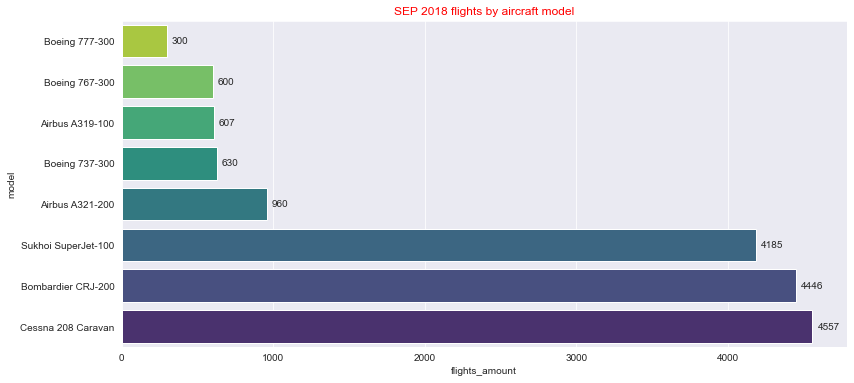

In [7]:
sns.set_style("darkgrid")
plt.figure(figsize=(13,6))
ax = sns.barplot(y='model', x='flights_amount', data=model, palette="viridis_r")

for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.title('SEP 2018 flights by aircraft model', color='red');

Дополнительно посмотрим на распределение долей на круговой диаграмме

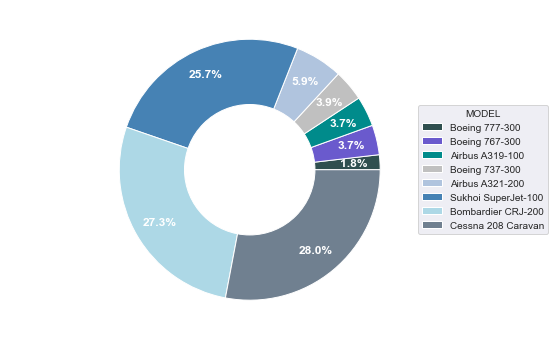

In [8]:
def donut(data, values, labels, title):
    my_colors={'lightblue','lightsteelblue','silver', 'slategrey', 'slateblue', 'darkcyan', 'darkslategrey', 'steelblue'}
    fig, axes = plt.subplots(figsize=(6, 6))
    axes.pie(
    data[values], 
    autopct="%.1f%%", 
    labels=data[labels], 
    colors=my_colors,
    textprops={'color':"w", 'fontsize':12, 'weight': 'bold'},
    pctdistance=0.8   
    )
    axes.legend(
    title=title, 
    loc='center left', 
    bbox_to_anchor=(1, 0, 0.5, 1)
    )
    ax.axis('equal')
    
    centre_circle = plt.Circle((0, 0), 0.50, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle);
    
    return fig, axes

model_donut = donut(model, 'flights_amount', 'model', 'MODEL')

В нашем списке 3 явных лидера по количеству рейсов (и соответственно доле) в сентябре 2018 года: 
- Sukhoi SuperJet-100
- Bombardier CRJ-200
- Cessna 208 Caravan

**Bombardier CRJ-200** - это семейство региональных самолётов, производимых канадской компанией Bombardier и основанных на бизнес-джете Canadair Challenger. CRJ200 имеют повышенные эксплуатационные характеристики: данный тип способен выполнять полёты в сложных метеорологических условиях и в условиях высокогорных аэродромов. Самолет расчитан на 50 пассажиров и предназначен в-основном для совершения авиаперевозок внутри одной страны или региона. Помимо иностранных компаний, Bombardier CRJ-200 эксплуатируют российские перевозчики: ИрАэро, РусЛайн, Северсталь, ЮВТ-Аэро, Ямал. 

Источники:  
https://ru.wikipedia.org/wiki/Bombardier_CRJ200  
https://www.airlines-inform.ru/commercial-aircraft/bombardier-crj-200.html

**Cessna 208 Caravan** -  американский лёгкий одномоторный турбовинтовой самолёт общего назначения с неубирающимся шасси. Базовая модель перевозит девять пассажиров (до 13 пассажиров + 1 пилот по разрешению FAA). В России операторами Cessna являются Авиакомпания СКОЛ, АэроГео.  
Источники:  
https://ru.wikipedia.org/wiki/Cessna_208  
https://www.airlines-inform.ru/commercial-aircraft/cessna-caravan.html

**Sukhoi SuperJet-100** - единственный в нашем списке самолет российского производства. Предназначен для перевозки от 87 до 108 пассажиров на дальность 3050 или 4600 км. Среди российских эксплуатантов Аэрофлот, Якутия, ГазпромАвиа, Московия, Ямал и другие. 
Источники:  
https://ru.wikipedia.org/wiki/Sukhoi_Superjet_100

Учитывая то, что самолеты  Sukhoi SuperJet-100 эксплуатируются лишь с 2011 года (тогда как Цессну начали выпускать в далеком 1982 году, а Бомбардье - в 1991), и до разработки данной модели ОКБ "Гражданские самолеты Сухого" специализировались на тактической авиации, а не на гражданской, мы считаем, что нахождение Суперджет-100 в числе лидеров по количеству рейсов в месяц - отличный показатель для отечественного самолетостроения, что бы ни говорили злопыхатели.

Модель с минимальным количеством рейсов в рассматриваемом периоде - **Boeing 777-300**. Это самолет вместимостью до 550 пассажиров, предназначенный для авиалиний большой протяженности. Основные компании-эксплуатанты в России - Аэрофлот и Россия.
Малое количество рейсов можно частично объяснить большой вместимостью модели: там где бизнес-джет перевозит 10 или 50 пассажиров за 4.5 тысячи рейсов в месяц (то есть теоретически Цессны при полной загрузке за месяц перевезут совокупно 222 300 пассажиров), Boeing 777-300 - в общей сложности 165 тысяч человек. Однако, мы считаем, что для сравнения Cessna, Bombardier и Boeing 777 не совсем корректно использовать метрики "количество совершенных рейсов в месяц" и "количество перевезенных пассажиров". Эти модели предназначены для разных перелетов (близкие / дальние), разных условий эксплуатации (длина взлетно-посадочной полосы, инфраструктура принимающего аэропорта, осложненные метеорологические условия или возможность посадки на снег / воду), и разных категорий пассажиров. Самолеты небольшой вместимости часто выбирают пассажиры бизнес-класса для частных перелетов, в то время как значительную долю пассажиров огромных боингов составляет эконом-класс.

Практически равны по количеству рейсов модели **Boeing 737-300** (среднемагистральный, вместимость 149 пассажиров), **Boeing 767-300** (перелеты средней и большой дальности, в том числе трансатлантические, вместимость до 325 пассажиров для чартерных рейсов) и **Airbus A319-100**	(малая и средняя дальность, до 156 пассажиров).

И последняя модель с нашем списке - **Airbus A321-200**. Это среднемагистральный самолет европейского производства, основной конкурент Boeing 737-300 (вместимость 170 мест или 220 мест для чартерных перевозок в одном классе). Аэробус А321 обошел вышеупомянутых представителей Boeing и Airbus на треть по количеству рейсов в месяц (доля - 6%).

Давайте теперь проанализируем среднее количество перелетов в день в разрезе города назначения

In [9]:
city = city.sort_values(by='average_flights', ascending=False)

city_grouped = city.groupby('average_flights')['city'].apply(list).reset_index()
city_grouped.sort_values(by='average_flights', ascending = False)

average_flights                                               city
14              130                                           [Москва]
13               31                                  [Санкт-Петербург]
12               17                                      [Новосибирск]
11               12                                       [Красноярск]
10               11                                     [Екатеринбург]
9                10   [Ростов-на-Дону, Сочи, Ульяновск, Пермь, Брянск]
8                 9                                [Сургут, Советский]
7                 8            [Казань, Ханты-Мансийск, Новый Уренгой]
6                 7                     [Челябинск, Тюмень, Хабаровск]
5                 6  [Петрозаводск, Иркутск, Мирный, Киров, Новокуз...
4                 5  [Архангельск, Элиста, Оренбург, Воркута, Волго...
3                 4  [Йошкар-Ола, Нижнекамск, Южно-Сахалинск, Пенза...
2                 3  [Самара, Усть-Илимск, Удачный, Омск, Ноябрьск,...
1                 2  [Кемерово, Белоярский, Курск, Ставрополь, Урай...
0                 1  [Анадырь, Братск, Благовещенск, Усть-Кут, Стре...

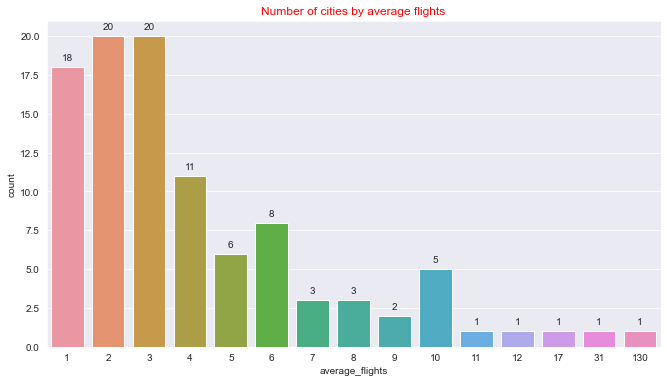

In [10]:
plt.figure(figsize=(11,6))
ax = sns.countplot(city['average_flights'])
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 
plt.title('Number of cities by average flights', color='red');

2/3 представленных в выборке городов принимают не более 4 рейсов в день.

Крупные транспортные хабы (Москва, Санкт-Петербург, Новосибирс, Красноярск, Екатеринбург) - более 10. Лидер по количеству рейсов - Москва (130). 

Интересно, что город-курорт Сочи стоит в одном ряду с Брянском, Пермью и Ульяновском - около 10 рейсов в день. Выборка охватывает данные за август 2018 года - летний месяц, когда пассажиропоток в южные города должен быть максимальным. Увы, в нашей таблице отсутствуют данные о вместимости самолетов, осуществляющих рейсы в данные города, а также об их заполняемости - поэтому на данном этапе мы не можем произвести корректное сравнение.

По-настоящему удивил небольшой город Советский, принимающий 9 рейсов в день. Это небольшой городок в Ханты-мансийском автономном округе - Югре с населением на 2021 год не более 30 000 человек. До 1996 года Советский был поселком. Основная отрасль промышленности - лесозаготовка и переработка древесины. Что же такого необычного в этом городе? 

<div>
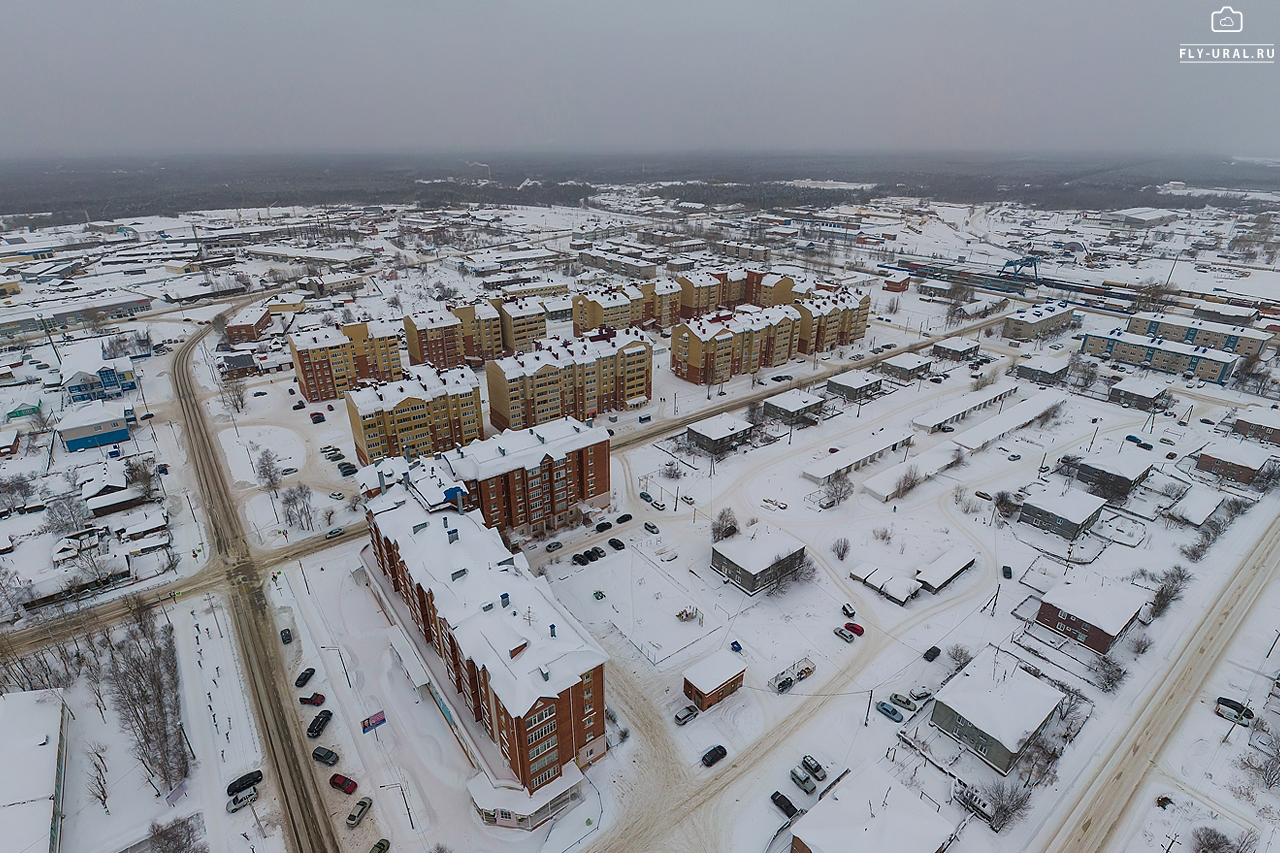
</div>

В Советском функционирует аэропорт Советский, основным родом деятельности которого является *вертолётное сообщение с северными посёлками, не имеющими автомобильной дороги*. Также регулярно выполняются авиарейсы Советский — Белоярский, Советский — Москва (Внуково), Советский — Тюмень, Советский — Екатеринбург. С мая 2016 года выполняются также и рейсы по маршруту Советский — Санкт-Петербург, где перевозчиком является Авиапредприятие «Северсталь».

Аэропорт Советский связывает отдаленные поселки крайнего севера с большой землей, и зачастую авиация - единственный доступный вид транспорта для местных жителей и вахтовиков. Скорее всего там летают легкие небольшие самолеты, способные осуществить взлет и посадку в сложных условиях. Большое количество рейсов в день, несмотря на скромный размер города) может объясняться особой ролью города на данной территории (если только мы не имеем дело с сезонностью, поскольку выбор месяца был случаен). 

Посмотрим распределение количества рейсов по городам на графике

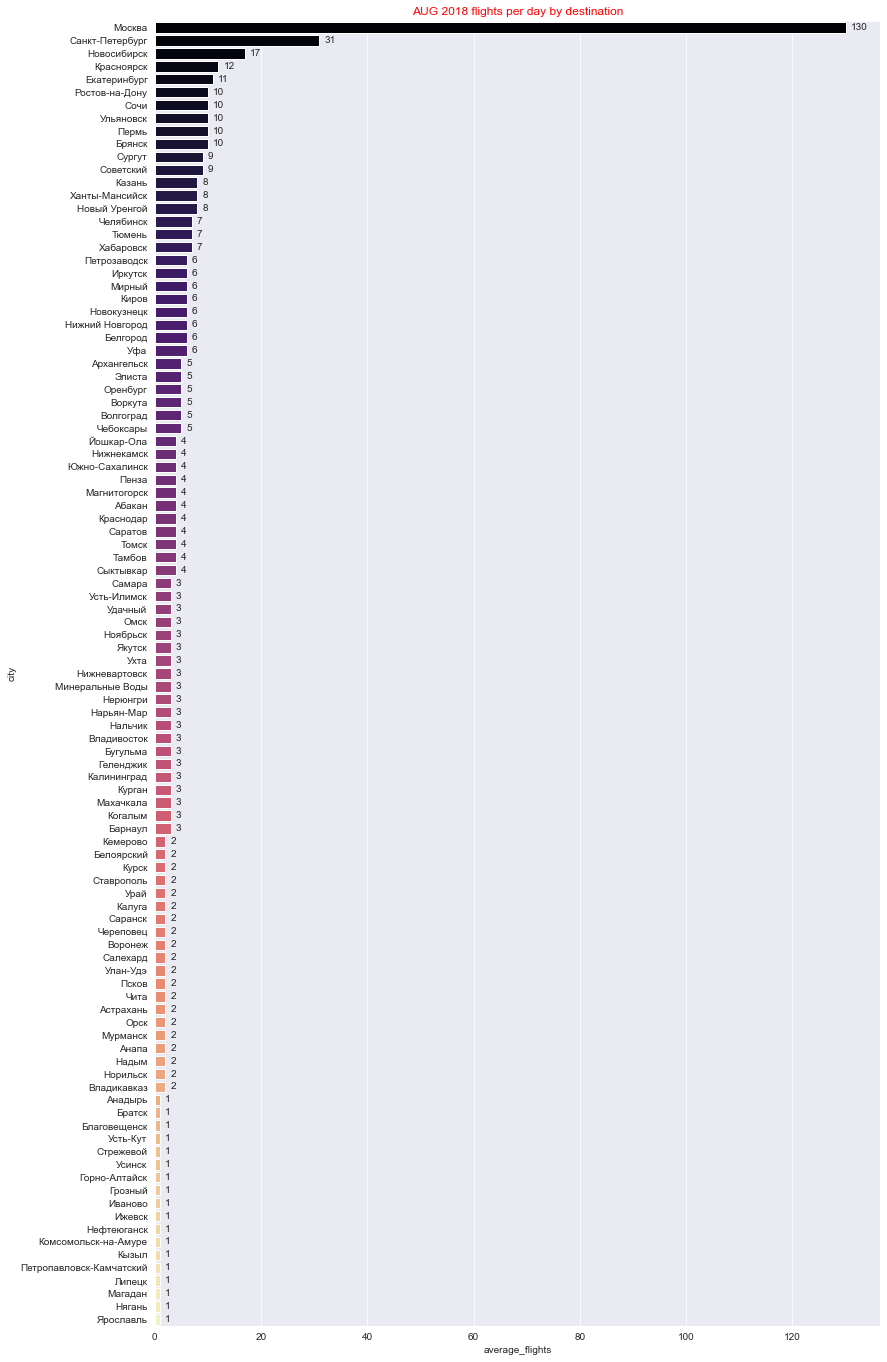

In [11]:
plt.figure(figsize=(13,24))
ax = sns.barplot(y='city', x='average_flights', data=city, palette="magma")

for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.title('AUG 2018 flights per day by destination', color='red');

Города Южного Федерального округа (за исключением Сочи) не отличаются большим количеством рейсов - 1-3 рейса в среднем. Аналогичная картина и для максимально удаленных от Москвы городов (Петропавловск-Камчатский, Владивосток, Мурманск, Калининград, Анадырь), а также для небольших городов центральной России (Иваново, Псков, Калуга, Липецк). 

Интересным также показался Ижевск с 1 рейсом в день. А ведь это столица Удмуртии, "оружейная столица" России, где производят знаменитый автомат Калашникова, автомобили LADA и делают самые вкусные пельмешки в стране! Ижевск занимает 20-е место в России по численности населения. Несправедливо.

<div>
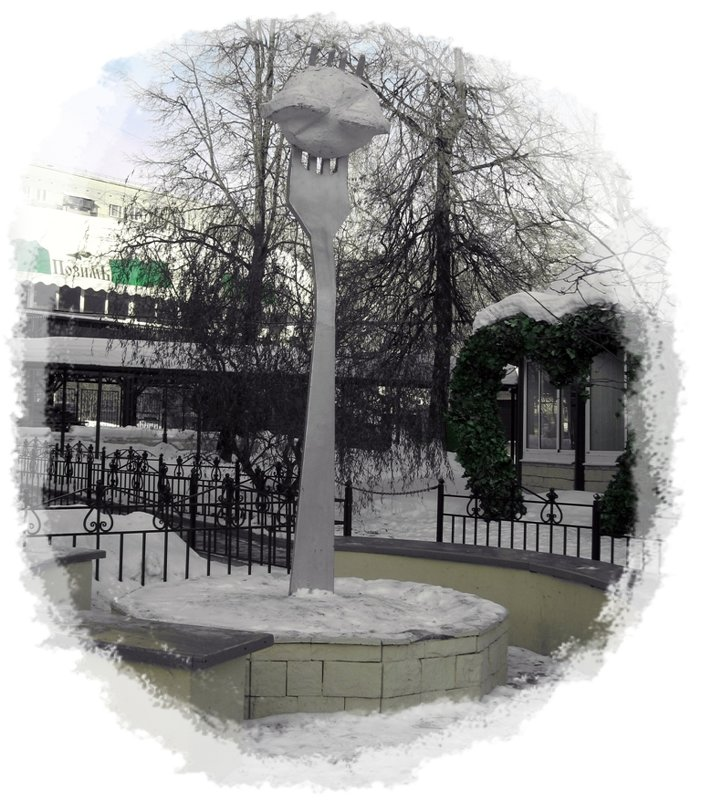
</div>

Россия - страна контрастов. Для Домодедово, Шереметьево и Внуково полсотни рейсов в день - это норма, а в Нягани и один рейс - это событие! Интересно, распределение значений среднего количества рейсов также не подчиняется закону нормальности?

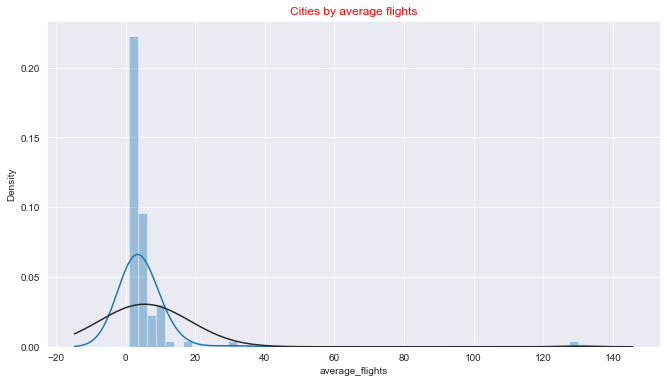

In [12]:
plt.figure(figsize=(11,6))
ax = sns.distplot(city['average_flights'], fit=norm)
plt.title('Cities by average flights', color='red');

Синяя линия на графике - кривая распределения наших данных. Черная - теоретическое нормальное распределение. У нашего распределения большая часть значений сконцентрирована в диапазоне от 1 до 4, и явно присутствуют выбросы после отметки 20

In [13]:
fig = px.box(city, y="average_flights")
fig.show()

Диаграмма размаха отлично демонстрирует наши наблюдения - третий квартиль в районе 6 означает, что 75% всех значений не превышают 6 рейсов в день. Верхняя граница - 12, а все, что выше - это аномально большие значения (17, 31 и 130 - Новосибирск, Санкт-Петербург и Москва соответственно).

Рассмотрим наших лидеров более детально. Выделим ТОП-10 городов с максимальным количеством рейсов в день

In [14]:
top_10 = city.sort_values(by='average_flights', ascending=False).head(10)
top_10

city  average_flights
43           Москва              130
70  Санкт-Петербург               31
54      Новосибирск               17
33       Красноярск               12
20     Екатеринбург               11
67   Ростов-на-Дону               10
74             Сочи               10
84        Ульяновск               10
63            Пермь               10
10           Брянск               10

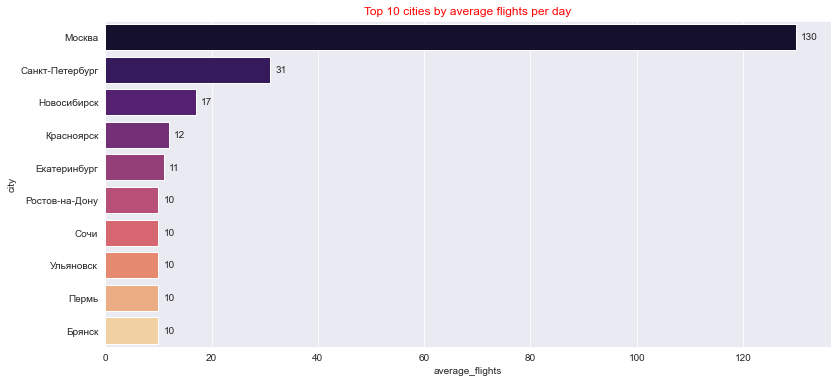

In [15]:
plt.figure(figsize=(13,6))
ax = sns.barplot(y='city', x='average_flights', data=top_10, palette="magma")
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.title('Top 10 cities by average flights per day', color='red');

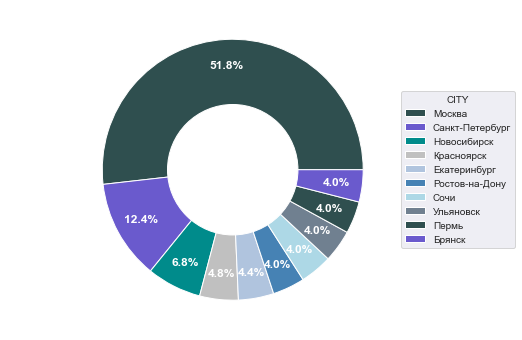

In [16]:
top_10_city_donut = donut(top_10, 'average_flights', 'city', 'CITY')

Как мы уже заметили ранее, Москва лидирует по количеству рейсов. На ее долю пришлось более половины всех пассажирских перевозок в исследуемом периоде (август 2018).

По опыту мы знаем, что транспортная сеть России организована такми образом, что не всегда между различными городами существуют прямые рейсы. Перелет с пересадкой в Москве - иногда единственный вариант добраться из точки А в точку Б на самолете (даже если расстояние по карте между пунктами в разы меньше, чем до Москвы и обратно). Инфраструктура столичных аэропортов позволяет обслуживать такое количество перелетов в день.

12,4% приходится на аэропорт северной столицы (Пулково). 16% авиа-трафика приходится в совокупности на 3 других крупных города России: Новосибирск, Красноярск и Екатеринбург. Доли остальных городов из ТОП-10 равны - по 4% каждая.

Ульяновск, Пермь, Брянск, Ростов-на-Дону - крупные административные центры, столицы областей. Из них Пермь и Ростов-на-Дону - это города-миллионники, население Брянска около 400 тысяч человек, Ульяновска - 625 тысяч.

Из всех городов, попавших в ТОП, только Сочи не является официально областной столицей. Однако это крупнейший город-курорт России, наша всесезонная южная "столица". Население города - 432 тысячи человек. В 2007 году Сочи был избран столицей XXII зимних Олимпийских игр, а в 2018 принял матчи Чемпионата мира по футболу. Город обладает развитой инфраструктурой, является крупным транспортным узлом юга России. 

## Общий вывод

Мы проанализировали выборку из базы данных по внутренним пассажирским авиаперевозкам за период август-сентябрь 2018 года. 

В исследование попали 8 моделей самолетов (3 модели Boeing, 2 Airbus, Sukhoi SuperJet-100, Bombardier CRJ-200 и
Cessna 208 Caravan). Боинги и Аэробусы традиционно используются для перелетов средней и большой дальности и расчитаны на большое количество пассажиров. Бомбардье и Цесна - легкие самолеты небольшой вместимости, используются в-основном для внутрирегиональных перелетов, перевозки пассажиров в труднодоступные места (в том числе с посадкой на воду или снег), или для частных и корпоративных нужд. Сухой Суперджет - единственный самолет российского производства в выборке, предназначен для ближнемагистральных перелетов и имеет вместимость не более 108 человек.

Самую большую долю по среднему количеству рейсов в месяц занимают Цесна (28.0%), Бомбардье (27.3%) и Сухой Суперджет (25.7%). Оставшиеся 19% распределены между представителями семейств конкурирующих между собой Boeing и Airbus. Меньше всего перелетов за исследуемый период совершил самый крупный самолет - Boeing 777-300. Самолеты этой модели позволяют перевозить в салоне до 550 человек. Таким образом, наблюдается обратная зависимость между вместимостью самолета (и дальностью полета) и количеством совершенных рейсов в месяц. Крупные самолеты летают далеко, но редко, а компактные джеты - часто и недалеко.

В рамках настоящего исследования мы также изучили среднедневное количество рейсов, прибывающих в различные города России. 

Столичные аэропорты лидируют по количеству принимаемых рейсов - их доля составляет более 50%. Другими популярными направлениями являются Санкт-Петербург (31 рейс), Новосибирск (17 рейсов), Красноярск (12) и Екатеринбург (11 рейсов) - это административные центры федеральных округов, крупные экономические и промышленные центры, важные транспортные узлы. В августе 2018 на эти города пришлась почти треть всего внутреннего пассажирского трафика.

В ТОП-10 попали также города с десятью рейсами в день: это Ульяновск, Пермь, Ростов-на-Дону, Брянск и Сочи. Любопытно, что крупнейший город-курорт страны принимал в августе столько же рейсов, что и "обыкновенные" областные столицы. Возможно, популярность Сочи как дестинации немного переоценена маркетологами. В любом случае, для полноценных выводов необходимо провести дополнительный анализ, учитывающий количество пассажиров, класс, стоимость билета и другие факторы. 

Среди остальных городов привлек внимание небольшой город в ХМАО - Советский. Его население едва достигает 30 тысяч человек, однако в день туда прибывают около 9 рейсов. Дело в том, что аэропорт Советский осуществляет связь с "большой землей" отдаленных северных территорий, куда невозможно добраться наземным транспортом. Перевозки осуществляются вертолетами или небольшими ближне- и среднемагистральными самолетами. У жителей региона есть также возможность добраться на самолете до крупных городов (МСК, СПБ, Ханты-Мансийск, Анапа и др.). Не все северные аэропорты могут похвастаться таким трафиком.

Для городов юга России (Ставрополье, Кавказ), небольших городов Центральной России (Иваново, Калуга), а также и для максимально удаленных от столицы крупных населенных пунктов (Владивосток, Петропавловск-Камчатский, Калининград и др.) емкость составляет 1-3 рейса в день. 

Выводы, полученные в данном исследовании, могут быть использованы заказчиком при принятии решения о заключении контракта на закупку тех или иных моделей самолета или об открытии нового направления. Однако для получения полной картины необходимо провести более глубокий анализ, учитывающий следующие факторы:
- протяженность авиалинии на интересующем направлении
- популярность направления 
- реальная и потенциальная мощность пассажиропотока
- сезонность
- класс пассажиров
- эксплуатационные расходы для конкретной модели самолета
- инфраструктура аэропортов вылета и посадки 
- условия эксплуатации воздушного судна
- доступность, уровень развития и пассажироемкость маршрутов альтернативного вида транспорта (авто, жд) и др.